# Introduction
IMPORTANT: To retrieve the trained model with weights in another kernel is necessary to commit this code.

# Set up environment

In [1]:
!pip install --upgrade tensorflow

     |████████████████████████████████| 394.3 MB 9.9 kB/s 
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.4.0
    Uninstalling tensorflow-2.4.0:
      Successfully uninstalled tensorflow-2.4.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import math, re, os, sys
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets
from tensorflow import keras
from functools import partial
from sklearn.model_selection import train_test_split
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


# Detect TPU
What we're doing with our code here is making sure that we'll be sending our data across a TPU. What you're looking for is a printout of `Number of replicas: 8`, corresponding to the 8 cores of a TPU. If your printout instead says `Number of replicas: 1` you likely do not have TPUs enabled in your notebook.   

To enable TPUs navigate to the panel on the right and click on `Accelerator`. Choose TPU from the dropdown.  

If you'd like more TPU troubleshooting and optimization guidelines check out our **[Learn With Me: Troubleshooting and Optimizing TPUs video](https://youtu.be/BSeWHzjMHMU)**.  

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Device: grpc://10.0.0.2:8470
Number of replicas: 8


# Set up variables
We'll set up some of our variables for our notebook here. 

If by chance you're using a private dataset, you'll also want to make sure that you have the **Google Cloud Software Development Kit (SDK)** attached to your notebook. You can find the Google Cloud SDK under the `Add-ons` dropdown menu at the top of your notebook. Documentation for the **Google Cloud Software Development Kit (SDK)** can be found **[here](https://www.kaggle.com/product-feedback/163416)**.

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = KaggleDatasets().get_gcs_path()
WORK_DIR = '../input/cassava-leaf-disease-classification'
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [512, 512]
CLASSES = ['0', '1', '2', '3', '4']
RANDOM_STATE = 2021
EPOCHS = 25

# Load the data
If you've primarily worked with notebooks in Learn, you've maybe noticed that data import and formatting is taken care of for you. But because we're working with competition data we'll have to handle this part of the pipeline ourselves.   

The data we're working with have been formatted into `TFRecords`, which are a format for storing a sequence of binary records. `TFRecords` work _really_ well with TPUs, and allow us to send a small number of large files across the TPU for processing.   

If you'd like to learn more about `TFRecords` and maybe even try creating them yourself, check out this **[TFRecords Basics notebook](https://www.kaggle.com/ryanholbrook/tfrecords-basics)** and **[corresponding video](https://youtu.be/KgjaC9VeOi8)** from Kaggle Data Scientist Ryan Holbrook.  

Because our data consists of `training` and `test` images only, we're going to split our `training` data into `training` and `validation` data using the `train_test_split()` function. 

## Decode the data
In the code chunk below we'll set up a series of functions that allow us to convert our images into tensors so that we can utilize them in our model. We'll also normalize our data. Our images are using a "Red, Blue, Green (RBG)" scale that has a range of [0, 255], and by normalizing it we'll set each pixel's value to a number in the range of [0, 1]. 

In [5]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)/255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

If you think back to **[Intro to Machine Learning](https://www.kaggle.com/learn/intro-to-machine-learning)** you might remember how we set up variables like `X` and `y`, representing our `features`, `X`, and `prediction target`, `y`. This code is accomplishing something similar, although instead of using the labels `X` and `y`, our `features` are represented by the term `image` and our `prediction target` by the term `target`.  

You might also notice that this function accounts for unlabeled images. This is because our test image doesn't have any labels.  

In [6]:
def read_tfrecord(example, labeled):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return image, label
    idnum = example['image_name']
    return image, idnum

We'll use the following function to load our dataset. One of the advantages of a TPU is that we can run multiple files across the TPU at once, and this accounts for the speed advantages of using a TPU. To capitalize on that, we want to make sure that we're using data as soon as it streams in, rather than creating a data streaming bottleneck.

In [7]:
def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    return dataset

## A note on using train_test_split()
While I used `train_test_split()` to create both a `training` and `validation` dataset, consider exploring **[cross validation instead](https://www.kaggle.com/dansbecker/cross-validation)**.

In [8]:
TRAINING_FILENAMES, VALID_FILENAMES = train_test_split(
    tf.io.gfile.glob(GCS_PATH + '/train_tfrecords/ld_train*.tfrec'),
    test_size=0.2, random_state=RANDOM_STATE)

TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test_tfrecords/ld_test*.tfrec')

## Adding in augmentations 
You learned about augmentations in the **[Computer Vision: Data Augmentation](https://www.kaggle.com/ryanholbrook/data-augmentation)** lesson on Kaggle Learn, and here I've applied an augmentation available to us through TensorFlow. You can read more about these augmentations (as well as all of the other augmentations available to you!) in the **[TensorFlow tf.image documentation](https://www.tensorflow.org/api_docs/python/tf/image)**.  

If you're interested in learning how to create and use custom augmentations, check out these **[Rotation Augmentation GPU/TPU](https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96)** and **[CutMix and MixUp on GPU/TPU](https://www.kaggle.com/cdeotte/cutmix-and-mixup-on-gpu-tpu)** from Kaggle Grandmaster Chris Deotte.

In [9]:
def data_augment(image, label):
    # Thanks to the dataset.prefetch(AUTO) statement in the following function this happens essentially for free on TPU. 
    # Data pipeline code is executed on the "CPU" part of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image, size=[512, 512, 3])
    return image, label

### Another data augmentation

In [10]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(mode="horizontal"),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

## Define data loading methods
The following functions will be used to load our `training`, `validation`, and `test` datasets, as well as print out the number of images in each dataset.

In [11]:
def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)  
    dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE)  
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [12]:
def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALID_FILENAMES, labeled=True, ordered=ordered) 
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [13]:
def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [14]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [15]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)

print('Dataset: {} training images, {} validation images, {} (unlabeled) test images'.format(
    NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 16056 training images, 5341 validation images, 1 (unlabeled) test images


# Brief exploratory data analysis (EDA)
First we'll print out the shapes and labels for a sample of each of our three datasets:

In [16]:
print("Training data shapes:")
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())
print("Validation data shapes:")
for image, label in get_validation_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Validation data label examples:", label.numpy())
print("Test data shapes:")
for image, idnum in get_test_dataset().take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

Training data shapes:
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Training data label examples: [4 3 4 2 3 0 2 3 3 3 3 0 3 3 2 1 3 3 1 4 0 3 3 3 3 3 4 3 3 3 3 3 2 3 3 1 3
 3 3 3 0 2 3 3 3 3 1 3 2 3 3 3 1 3 0 1 3 3 2 3 3 3 4 3 3 3 3 1 3 1 3 3 3 3
 4 3 3 3 3 3 3 3 1 4 3 3 3 3 1 2 3 3 3 3 3 4 3 3 3 3 3 3 3 4 3 3 1 3 4 3 3
 4 3 2 3 3 3 0 3 2 2 4 3 3 3 3 3 2]
Validation data shapes:
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Validation data label examples: [2 4 3 3 0 2 4 4 2 3 3 4 3 2 1 3 3 2 3 4 1 3 3 0 3 3 3 3 1 3 3 3 2 4 3 3 1
 3 3 4 1 3 3 3 1 2 1 3 0 4 1 3 3 1 3 3 3 3 0 2 3 4 3 0 3 0 3 3 3 1 0 3 3 3
 2 3 4 3 3 3 3 3 3 3 4 3 3 3 3 3 2 2 3 0 1 3 3 3 3 3 0 2 3 3 3 3 3 1 3 3 3
 3 3 3 1 3 3 1 3 1 3 3 3 3 1 3 0 3]
Test data shapes:
(1, 512, 512, 3) (1,)
Test data IDs: ['2216849948.jpg']


### Basic look into the data

In [17]:
with open(os.path.join(WORK_DIR, "label_num_to_disease_map.json")) as file:
    print(json.dumps(json.loads(file.read()), indent=4))

{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


In [18]:
# Carregar arquivo train.csv
train_labels = pd.read_csv(os.path.join(WORK_DIR, "train.csv"))
train_labels

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


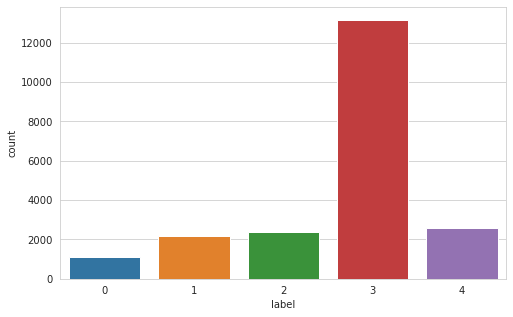

In [19]:
import seaborn as sns

plt.figure(figsize=(8,5))

sns.set_style('whitegrid')

ax=sns.countplot(data=train_labels, x='label')


#  '0': 'Cassava Bacterial Blight (CBB)
#  '1': 'Cassava Brown Streak Disease (CBSD)
#  '2': 'Cassava Green Mottle (CGM)
#  '3': 'Cassava Mosaic Disease (CMD)
#  '4': 'Healthy

In [20]:
CLASS_WEIGHT = dict(train_labels.label.value_counts()/train_labels.shape[0])
CLASS_WEIGHT

{3: 0.6149460204701593,
 4: 0.12043744450156564,
 2: 0.11151095948030097,
 1: 0.10230406131700706,
 0: 0.05080151423096696}

The following code chunk sets up a series of functions that will print out a grid of images. The grid of images will contain images and their corresponding labels.

In [21]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_plant(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_plant(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

In [22]:
# load our training dataset for EDA
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

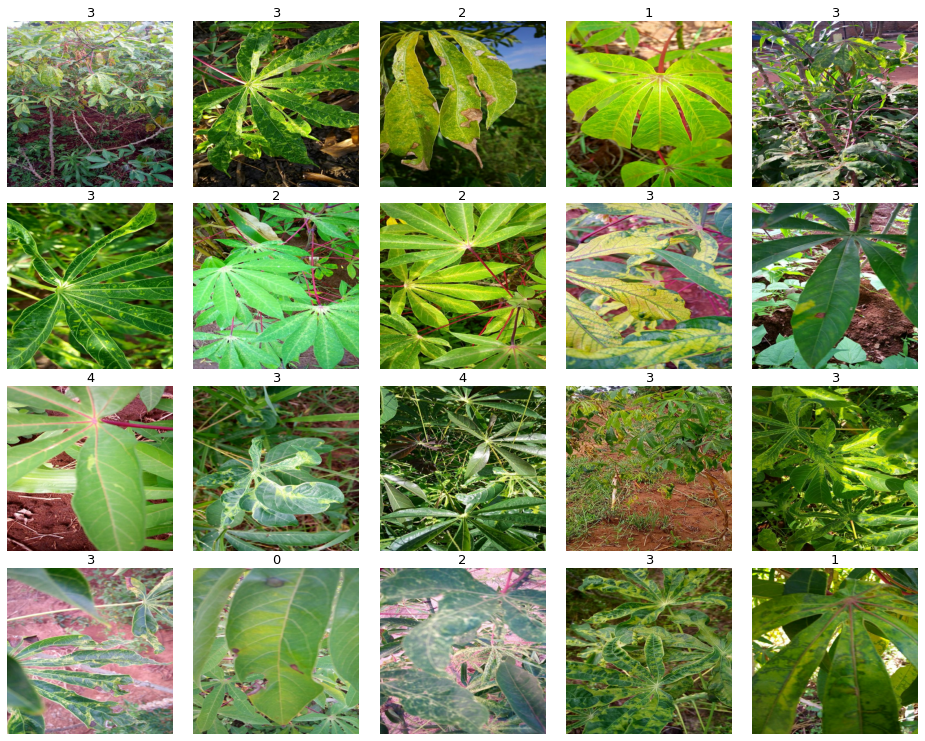

In [23]:
# run this cell again for another randomized set of training images
display_batch_of_images(next(train_batch))

# Building the model
## Learning rate schedule
We learned about learning rates in the **[Intro to Deep Learning: Stochastic Gradient Descent](https://www.kaggle.com/ryanholbrook/stochastic-gradient-descent)** lesson, and here I've created a learning rate schedule mostly using the defaults in the **[Keras Exponential Decay Learning Rate Scheduler](https://keras.io/api/optimizers/learning_rate_schedules/exponential_decay/)** documentation (I did change the `initial_learning_rate`. You can adjust the learning rate scheduler below, and read more about the other types of schedulers available to you in the **[Keras learning rate schedules API](https://keras.io/api/optimizers/learning_rate_schedules/)**.

In [24]:
lr_scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5, 
    decay_steps=10000, 
    decay_rate=0.9)

## Building our model
In order to ensure that our model is trained on the TPU, we build it using `with strategy.scope()`.    

This model was built using transfer learning, meaning that we have a _pre-trained model_ (ResNet50) as our base model and then the customizable model built using `tf.keras.Sequential`. If you're new to transfer learning I recommend setting `base_model.trainable` to **False**, but _do_ encourage you to change which base model you're using (more options are available in the **[`tf.keras.applications` Module](https://www.tensorflow.org/api_docs/python/tf/keras/applications)** documentation) as well iterate on the custom model. 

Note that we're using `sparse_categorical_crossentropy` as our loss function, because we did _not_ one-hot encode our labels.

In [25]:

#with strategy.scope():       
#    img_adjust_layer = tf.keras.layers.Lambda(tf.keras.applications.resnet50.preprocess_input, input_shape=[*IMAGE_SIZE, 3])
    
#    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)
#    base_model.trainable = False
#    
#    model = tf.keras.Sequential([
#        tf.keras.layers.BatchNormalization(renorm=True),
#        img_adjust_layer,
#        base_model,
#        tf.keras.layers.GlobalAveragePooling2D(),
#        tf.keras.layers.Dense(8, activation='relu'),
#        #tf.keras.layers.BatchNormalization(renorm=True),
#        tf.keras.layers.Dense(len(CLASSES), activation='softmax')  
#    ])
#    
#    model.compile(
#        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler, epsilon=0.001),
#        loss='sparse_categorical_crossentropy',  
#        metrics=['sparse_categorical_accuracy'])

In [26]:
def build_model(num_classes):
    inputs = layers.Input(shape=(*IMAGE_SIZE, 3))
    x = img_augmentation(inputs)
    model = tf.keras.applications.EfficientNetB6(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2) #adicionar lr_schedule depois e ver diferença
    model.compile(
        optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy']
    )
    return model

In [27]:
NUM_CLASSES=len(CLASSES)

with strategy.scope():
    model = build_model(num_classes=NUM_CLASSES)

#epochs = 25  # @param {type: "slider", min:8, max:80}
#hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)
#plot_hist(hist)

165240832/165234480 [==============================] - 1s 0us/step


#Ver link: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

with strategy.scope():       
    base_model = tf.keras.applications.EfficientNetB6(
        include_top= False,
        weights="imagenet",
        input_shape= [*IMAGE_SIZE, 3],
        pooling='avg',
        classes= len(CLASSES),
        )
    base_model.trainable = False
    
    model = tf.keras.Sequential([
        tf.keras.layers.BatchNormalization(renorm=True),
        base_model,
        #tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')  
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler, epsilon=0.001),
        loss='sparse_categorical_crossentropy',  
        metrics=['sparse_categorical_accuracy'])

# Train the model
As our model is training you'll see a printout for each epoch, and can also monitor TPU usage by clicking on the TPU metrics in the toolbar at the top right of your notebook.

In [28]:
# load data
train_dataset = get_training_dataset()
valid_dataset = get_validation_dataset()
testing_dataset = get_test_dataset()

In [29]:
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE

history = model.fit(train_dataset, 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    epochs=EPOCHS,
                    validation_data=valid_dataset,
                    validation_steps=VALID_STEPS)
                    #class_weight=CLASS_WEIGHT)

Epoch 1/25


InvalidArgumentError: 9 root error(s) found.
  (0) Invalid argument: {{function_node __inference_train_function_86642}} Compilation failure: Detected unsupported operations when trying to compile graph cluster_train_function_960557099320400885[] on XLA_TPU_JIT: ImageProjectiveTransformV3 (No registered 'ImageProjectiveTransformV3' OpKernel for XLA_TPU_JIT devices compatible with node {{node EfficientNet/img_augmentation/random_rotation/transform/ImageProjectiveTransformV3}}){{node EfficientNet/img_augmentation/random_rotation/transform/ImageProjectiveTransformV3}}One approach is to outside compile the unsupported ops to run on CPUs by enabling soft placement `tf.config.set_soft_device_placement(True)`. This has a potential performance penalty.
	TPU compilation failed
	 [[tpu_compile_succeeded_assert/_1124255915990801790/_7]]
	 [[tpu_compile_succeeded_assert/_1124255915990801790/_7/_91]]
  (1) Invalid argument: {{function_node __inference_train_function_86642}} Compilation failure: Detected unsupported operations when trying to compile graph cluster_train_function_960557099320400885[] on XLA_TPU_JIT: ImageProjectiveTransformV3 (No registered 'ImageProjectiveTransformV3' OpKernel for XLA_TPU_JIT devices compatible with node {{node EfficientNet/img_augmentation/random_rotation/transform/ImageProjectiveTransformV3}}){{node EfficientNet/img_augmentation/random_rotation/transform/ImageProjectiveTransformV3}}One approach is to outside compile the unsupported ops to run on CPUs by enabling soft placement `tf.config.set_soft_device_placement(True)`. This has a potential performance penalty.
	TPU compilation failed
	 [[tpu_compile_succeeded_assert/_1124255915990801790/_7]]
	 [[tpu_compile_succeeded_assert/_1124255915990801790/_7/_171]]
  (2) Invalid argument: {{function_node __inference_train_function_86642}} Compilation failure: Detected unsupported operations when trying to compile graph cluster_train_function_960557099320400885[] on XLA_TPU_JIT: ImageProjectiveTransformV3 (No registered 'ImageProjectiveTransformV3' OpKernel for XLA_TPU_JIT devices compatible with node {{node EfficientNet/img_augmentation/random_rotation/transform/ImageProjectiveTransformV3}}){{node EfficientNet/img_augmentation/random_rotation/transform/ImageProjectiveTransformV3}}One approach is to outside compile the unsupported ops to run on CPUs by enabling soft placement `tf.config.set_soft_device_placement(True)`. This has a potential performance penalty.
	TPU compilation failed
	 [[tpu_compile_succeeded_assert/_1124255915990801790/_7]]
	 [[tpu_compile_succeeded_assert/_1124255915990801790/_7/_151]]
  (3) Invalid argument: {{function_node __inference_train_function_86642}} Compilation failure: Detected unsupported operations when trying to compile graph cluster_train_function_960557099320400885[] on XLA_TPU_JIT: ImageProjectiveTransformV3 (No registered 'ImageProjectiveTransformV3' OpKernel for XLA_TPU_JIT devices compatible with node {{node EfficientNet/img_augmentation/random_rotation/transform/ImageProjectiveTransformV3}}){{node EfficientNet/img_augmentation/random_rota ... [truncated]

With model.summary() we'll see a printout of each of our layers, their corresponding shape, as well as the associated number of parameters. Notice that at the bottom of the printout we'll see information on the total parameters, trainable parameters, and non-trainable parameters. Because we're using a pre-trained model, we expect there to be a large number of non-trainable parameters (because the weights have already been assigned in the pre-trained model).

In [30]:
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
img_augmentation (Sequential)   (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 512, 512, 3)  0           img_augmentation[0][0]           
__________________________________________________________________________________________________
normalization (Normalization)   (None, 512, 512, 3)  7           rescaling[0][0]                  
_______________________________________________________________________________________

# Evaluating our model
The first chunk of code is provided to show you where the variables in the second chunk of code came from. As you can see, there's a lot of room for improvement in this model, but because we're using TPUs and have a relatively short training time, we're able to iterate on our model fairly rapidly.

In [31]:
# print out variables available to us
print(history.history.keys())

NameError: name 'history' is not defined

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [32]:
# create learning curves to evaluate model performance
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot();

NameError: name 'history' is not defined

# Saving the model

In [33]:
model.save('model.h5')

# Making predictions
IMPORTANT: This part will runned in another notebook without TPU accelerator.

In [34]:
# this code will convert our test image data to a float32 
def to_float32(image, label):
    return tf.cast(image, tf.float32), label

In [35]:
test_ds = get_test_dataset(ordered=True) 
test_ds = test_ds.map(to_float32)

print('Computing predictions...')
test_images_ds = testing_dataset
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

Computing predictions...
[0]


# Creating a submission file
Now that we've trained a model and made predictions we're ready to submit to the competition! You can run the following code below to get your submission file.

In [36]:
# print('Generating submission.csv file...')
# test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
# test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
# np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')
# !head submission.csv

Be aware that because this is a code competition with a hidden test set, internet and TPUs cannot be enabled on your submission notebook. Therefore TPUs will only be available for training models. For a walk-through on how to train on TPUs and run inference/submit on GPUs, see our [TPU Docs](https://www.kaggle.com/docs/tpu#tpu6).